# Planar Homography

## Imports

In [118]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Auxiliar functions

In [119]:
def get_intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                 [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x, y = np.linalg.solve(A, b)
    x, y = int(x), int(y)
    return (x, y)


In [120]:
def order_points(pts):
    '''Rearrange coordinates to order:
       top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left point will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()


### Read and display original image

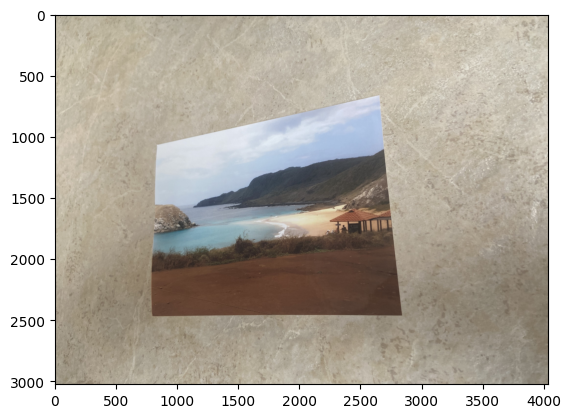

In [121]:
original = cv2.imread('./img/foto1_cap1.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # check whether this is going to cause problems
plt.imshow(original)
plt.show()

### Resize to workable dims

In [122]:
dim_limit = 1080
max_dim = max(original.shape[:2])
if max_dim > dim_limit:
    resize_scale = dim_limit / max_dim
    original = cv2.resize(original, None, fx=resize_scale, fy=resize_scale)

### Image transforms and morph ops

In [123]:
# convert image to grayscale/blurred versions
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image to create a binary image
ret, thresh = cv2.threshold(
    blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# perform morphological transformations to remove noise
kernel = np.ones((24, 24), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

### Background and foreground analysis

In [124]:
# sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=35)

# find sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# find unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# add one to all labels so that sure background is not 0, but 1
markers = markers+1

# mark the region of unknown with zero
markers[unknown == 255] = 0

### Watershed

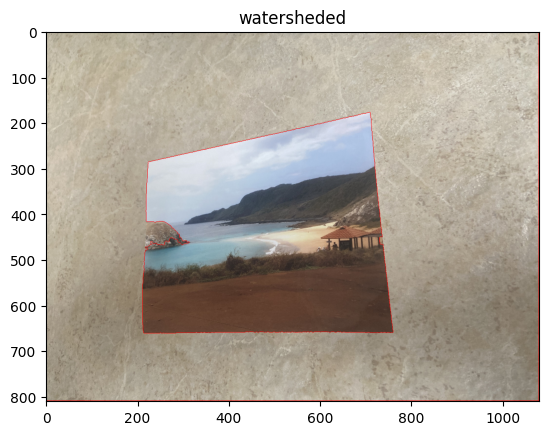

In [125]:
watersheded = original.copy()
markers = cv2.watershed(watersheded, markers)
watersheded[markers == -1] = [255, 0, 0]
plt.imshow(watersheded)
plt.title('watersheded')
plt.show()

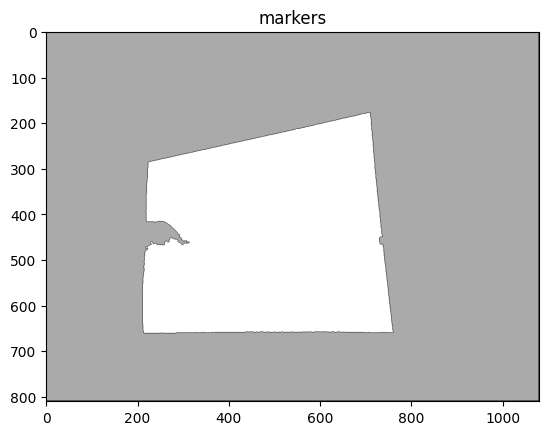

In [126]:
plt.imshow(markers, cmap='gray')
plt.title('markers')
plt.show()

### Hough lines

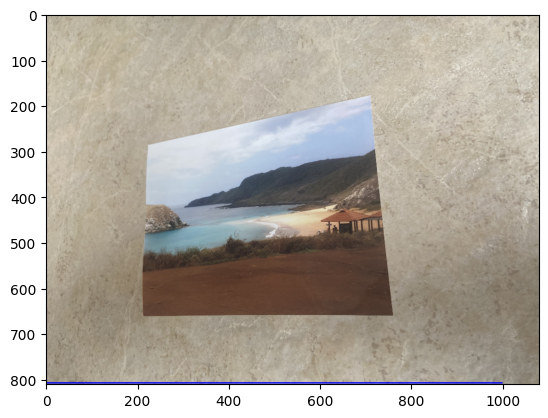

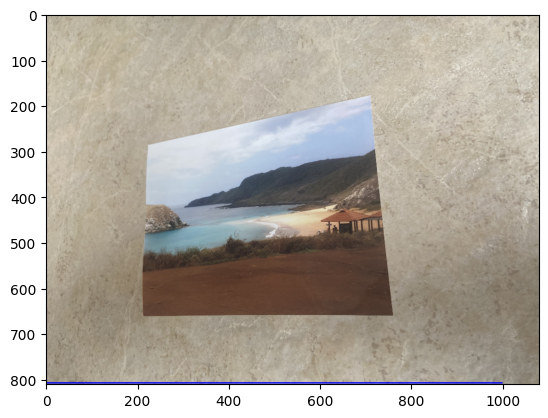

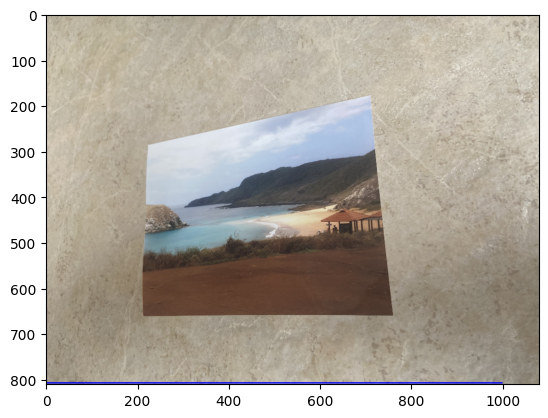

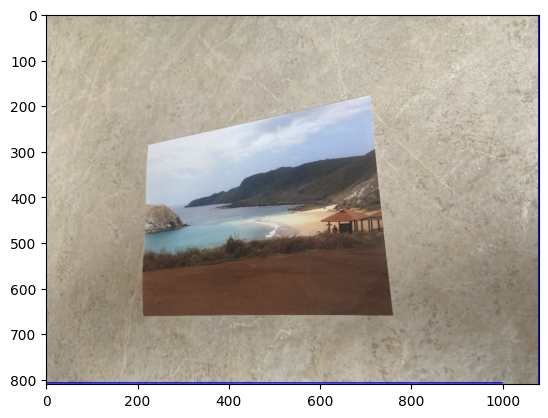

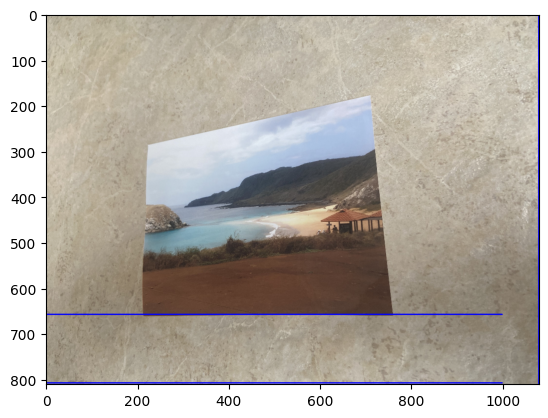

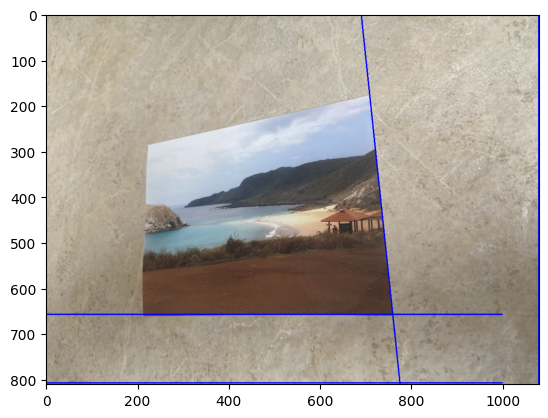

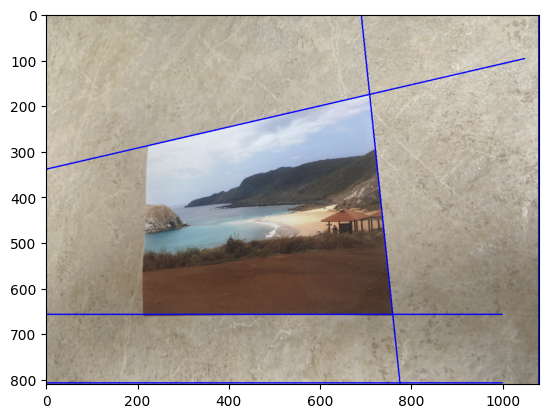

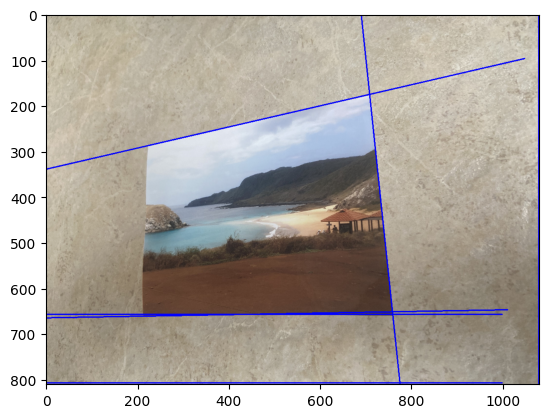

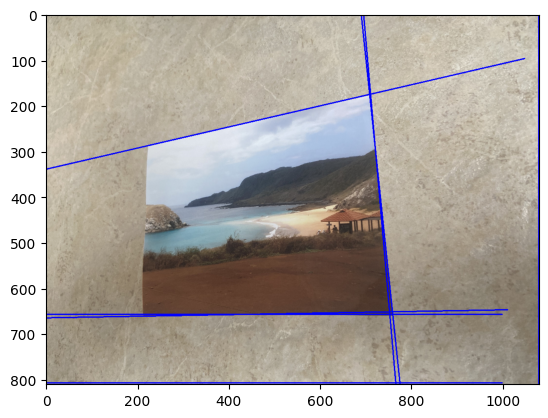

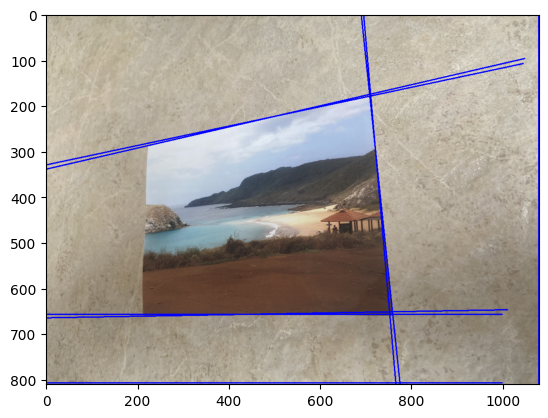

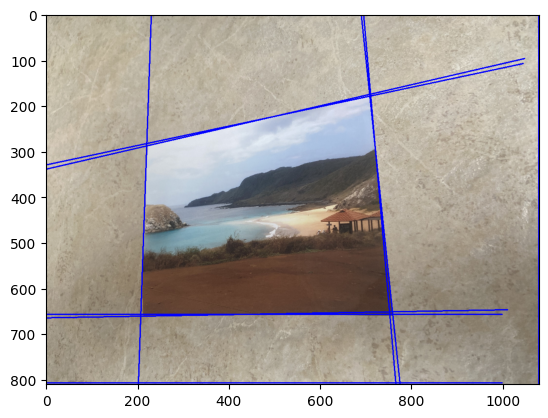

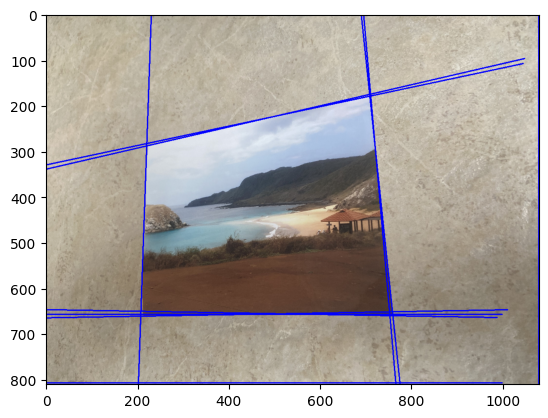

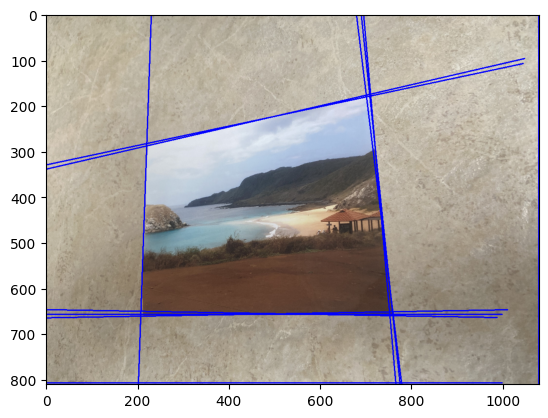

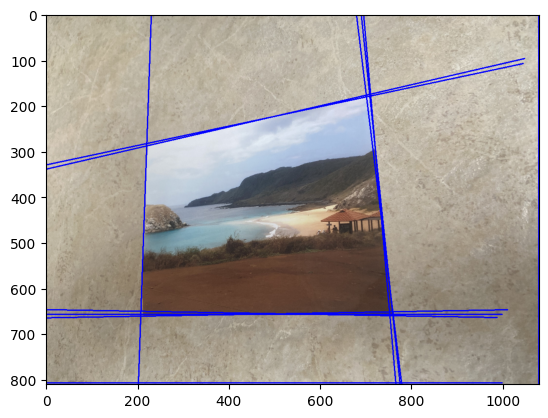

In [131]:
# generate mask image
mask = np.zeros(original.shape[:2], np.uint8)
mask[markers == -1] = 255

# perform hough line transform over the mask
lines = cv2.HoughLines(mask, 2, np.pi/180, 150)

# draw lines on the image
lined_img = original.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(lined_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    plt.imshow(lined_img)
    plt.show()

# show the image with the lines drawn on it
plt.imshow(lined_img)
plt.show()


[GRAB INTERSECTIONS](https://stackoverflow.com/a/46572063)

### Binarize marker image

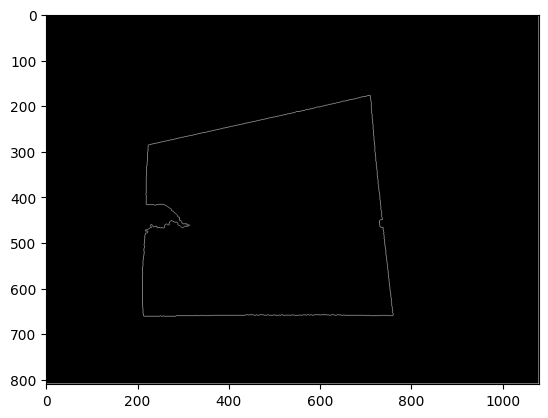

In [128]:
maxval = 255
im_bin = (markers == -1)
im_bin = im_bin.astype('uint8')
plt.imshow(im_bin, cmap='gray')
plt.show()


### Contour detection

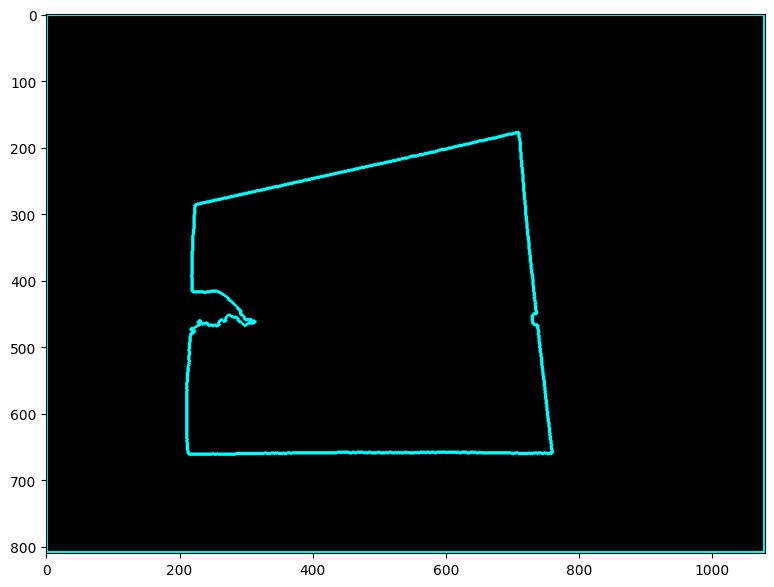

In [129]:
# Blank canvas
con = np.zeros_like(original)
# Finding contours for the detected edges
contours, hierarchy = cv2.findContours(
    im_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the latest detected contour
page = sorted(contours, key=cv2.contourArea, reverse=True)[:3]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)

plt.figure(figsize=(10, 7))
plt.imshow(con, cmap='gray')
plt.show()


### Corner detection using DP algorithm

[[0, 0], [1079, 0], [1079, 809], [0, 809]]


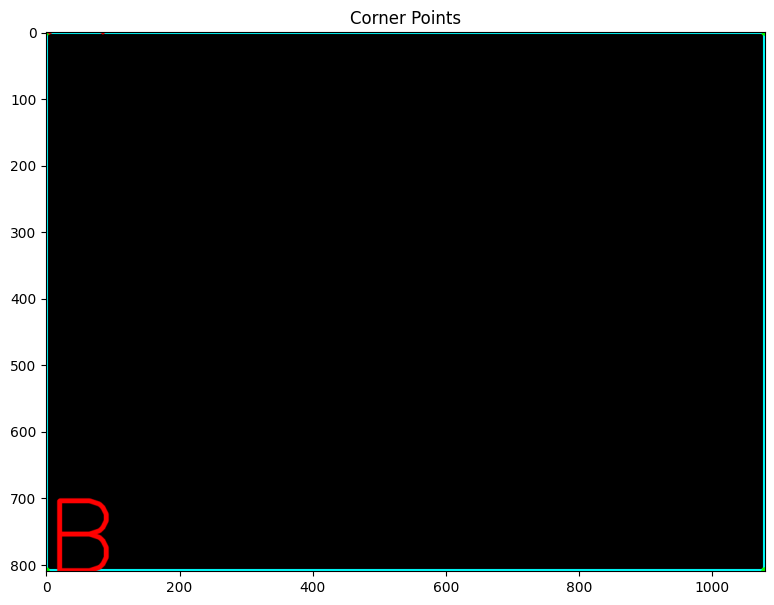

In [130]:
# Blank canvas
con = np.zeros_like(original)
# Loop over the contours.
for c in page:
    # Approximate the contour.
	epsilon = 0.02 * cv2.arcLength(c, True)
	corners = cv2.approxPolyDP(c, epsilon, True)
	# If our approximated contour has four points
	if len(corners) == 4:
		break

cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# displaying corners
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX,
                5, (255, 0, 0), 5, cv2.LINE_AA)

# rearranging the order of the corner points.
corners = order_points(corners)

print(corners)

plt.figure(figsize=(10, 7))
plt.imshow(con)
plt.title('Corner Points')
plt.show()
